In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras
import sys
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

/var/folders/53/7nrg8r4x06v4f93ty4vc4yzc0000gn/T/ipykernel_14272/2988118115.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DATA_PATH = "./data"

In [3]:
# load data

def load_image(image_id:str):
    image_id = image_id.split('.')[0] if image_id.endswith('.png') else image_id.split('.')[0] if image_id.endswith('.png') else image_id
    file_path = image_id + ".png"
    image = cv.imread(file_path)
    image = cv.resize(image, (300,300))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def load_data() -> dict:
    # load data
    data_dir = './data'
    os.chdir(data_dir)
    dir_list = os.listdir()
    dir_list.sort()
    data = dict()
    for dir_name in tqdm(dir_list, desc='Loading data', colour='green'):
        os.chdir(dir_name)
        image_list = [load_image(x) for x in os.listdir() if x.lower().endswith('.png')]
        # print(dir_name, len(image_list))
        data[dir_name] = image_list
        os.chdir('..')
    os.chdir('..')
    return data

In [4]:
#plot image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

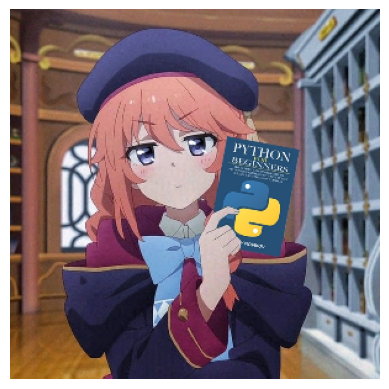

In [5]:
# TEST CODE
test_jpg = load_image('test.png')
plot_image(test_jpg)

In [6]:
# load all data
data = load_data()

Loading data:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


In [7]:
NUM_CLASSES = len(data.keys())
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


In [8]:
# normalize data
def normalize_data(data: dict) -> dict:
    return {k: [x/255.0 for x in v] for k, v in data.items()}

nor_data = normalize_data(data)
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


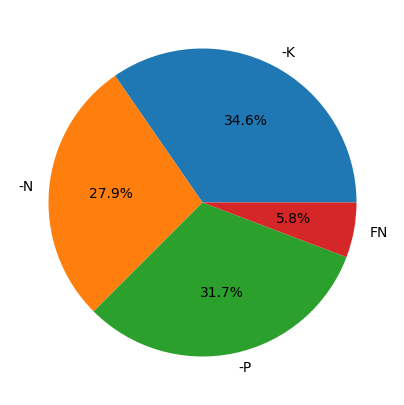

In [9]:
# plot pie chart of data(labels)
def plot_pie_chart(data: dict):
    plt.figure(figsize=(5, 5))
    plt.pie([len(x) for x in data.values()], labels=[x for x in data.keys()], autopct='%1.1f%%')
    plt.show()

def plot_bar_chart_df(data: pd.DataFrame):
    data.plot(kind='pie', subplots=True, figsize=(5, 5))
    plt.show()

plot_pie_chart(nor_data)

In [10]:
df = pd.DataFrame({'image': [x for x in nor_data.values() for x in x], 'label': [x for x in nor_data.keys() for _ in range(len(nor_data[x]))]})
df.head()

,image,label
0,"[[[0.9725490196078431, 0.9686274509803922, 0.9...",-K
1,"[[[0.9450980392156862, 0.9411764705882353, 0.9...",-K
2,"[[[0.8941176470588236, 0.9294117647058824, 0.9...",-K
3,"[[[0.9490196078431372, 0.9607843137254902, 0.9...",-K
4,"[[[0.9647058823529412, 0.9803921568627451, 0.9...",-K


In [11]:
# Data Augmentation for label "FN"
def data_augmentation1(image):
    image = cv.flip(image, 1)
    return image

def data_augmentation2(image):
    image = cv.flip(image, 0)
    return image

def data_augmentation3(image):
    image = cv.flip(image, -1)
    return image

df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation1)
df_aug['label'] = 'FN'
df = pd.concat([df, df_aug], ignore_index=True)
df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation2)
df_aug['label'] = 'FN'
df:pd.DataFrame = pd.concat([df, df_aug], ignore_index=True)
df_aug = df
df_aug['image'] = df_aug['image'].apply(data_augmentation3)
df:pd.DataFrame = pd.concat([df, df_aug], ignore_index=True)

/var/folders/53/7nrg8r4x06v4f93ty4vc4yzc0000gn/T/ipykernel_14272/2868462567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['image'] = df_aug['image'].apply(data_augmentation1)
/var/folders/53/7nrg8r4x06v4f93ty4vc4yzc0000gn/T/ipykernel_14272/2868462567.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['label'] = 'FN'
/var/folders/53/7nrg8r4x06v4f93ty4vc4yzc0000gn/T/ipykernel_14272/2868462567.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [12]:
print(f"Number of classes: {len(df['label'].unique())}, Number of images: {len(df)}")

Number of classes: 4, Number of images: 488


array([<Axes: ylabel='proportion'>], dtype=object)

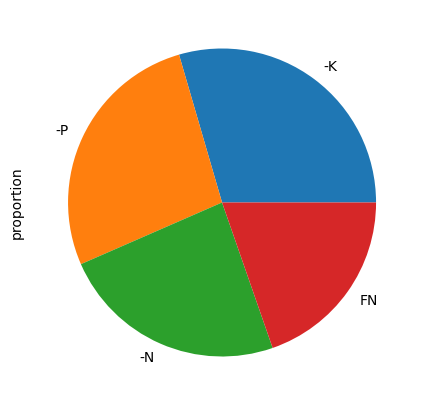

In [13]:
df.value_counts('label', normalize=True).plot(kind='pie', subplots=True, figsize=(5, 5))

In [14]:
# save as csv
df.to_csv('data.csv', index=False)

In [15]:
# Label Encoding
def label_encoding(label):
    encoder = LabelEncoder()
    label = encoder.fit_transform(label)
    return label, encoder

df['label'], encoder = label_encoding(df['label'])
df.head()

,image,label
0,"[[[0.9450980392156862, 0.9490196078431372, 0.9...",0
1,"[[[0.9882352941176471, 0.9921568627450981, 0.9...",0
2,"[[[0.6784313725490196, 0.7254901960784313, 0.6...",0
3,"[[[0.9490196078431372, 0.9607843137254902, 0.9...",0
4,"[[[0.9176470588235294, 0.9058823529411765, 0.8...",0


In [16]:
for i, x in enumerate(encoder.classes_):
    print(f"Class {i}: {x}")

Class 0: -K
Class 1: -N
Class 2: -P
Class 3: FN


In [17]:
# Turn data into tensor and split data
def split_data(data: dict, test_size: float=0.2) -> tuple:
    X = np.array([x for x in data['image']])
    y = np.array([x for x in data['label']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df.to_dict('list'))
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (390, 300, 300, 3), y_train: (390,), X_test: (98, 300, 300, 3), y_test: (98,)


In [18]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (390, 300, 300, 3), y_train shape: (390,)
X_test shape: (98, 300, 300, 3), y_test shape: (98,)


In [ ]:
# save as npz

np.savez('data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# save encoder
np.savez('encoder.npz', classes=encoder.classes_)